In [3]:
import pandas as pd
eye_tracking_data = pd.read_csv('data/raw_data_0317.csv')

In [4]:
# 查看data的结构
eye_tracking_data.head(1)

,Unnamed: 0,uid,page_id,text_sequences,eye_tracking_sequences,labels
0,0,ys,1226,"[[0, 'A', 330, 95, 32, 52], [1, 'judge', 362, ...","[[499, 499, 15], [499, 497, 10470], [497, 490,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# 跳读幅度

In [11]:
import math

class EyeTrackingDataEvaluate:
    def __init__(self, eye_tracking_data_list, window_size) -> None:
        self.data_list = eye_tracking_data_list # [x, y, timestamp, page_id]
        self.window_size = window_size

    def RmsScore(self) -> float:
        res = 0.0
        for i in range(len(self.data_list)):
            if i == 0:
                continue
            diff_x = self.data_list[i][0]-self.data_list[i-1][0]
            diff_y = self.data_list[i][1]-self.data_list[i-1][1]
            res += pow(diff_x, 2) + pow(diff_y, 2)
        res = math.sqrt(res/len(self.data_list))
        return res

    def STDWindowScore(self) -> float:
        res = 0.0
        dataCluster = [] # 记录聚合了的眼动
        for i in range(len(self.data_list)):
            if len(dataCluster) == 0:
                dataCluster.append(self.data_list[i])
            else:
                if self.data_list[i][2] - dataCluster[0][2] > self.window_size:
                    res += self.SquareVal(dataCluster)
                    dataCluster = []
                else:
                    dataCluster.append(self.data_list[i])
            if i == len(self.data_list) - 1 and len(dataCluster) > 0:
                res += self.SquareVal(dataCluster)
                dataCluster = []
        res = math.sqrt(res/len(self.data_list))
        return res

    def SquareVal(self, data_list):
        res = 0
        avg_x = sum([data[0] for data in data_list]) / len(data_list)
        avg_y = sum([data[1] for data in data_list]) / len(data_list)
        for data in data_list:
            res += pow(data[0] - avg_x, 2) + pow(data[1] - avg_y, 2)
        return res

    def FinalScore(self) -> int:
        rmsScore = self.RmsScore()
        stdScore = self.STDWindowScore()
        finalScore = math.sqrt(pow(rmsScore, 2) + pow(stdScore, 2))
        # print(f"finalScore={finalScore}, rmsScore={rmsScore}, stdScore={stdScore}")
        return finalScore

In [12]:
class EyeTrackingData:
    def __init__(self, eye_tracking_sequences, page_id) -> None:
        self.eye_tracking_sequences = eye_tracking_sequences
        self.page_id = page_id

In [13]:
# 构造数据
eye_tracking_data_list = [] # page维度
for idx, row in eye_tracking_data.iterrows():
    eye_tracking_data_list.append(EyeTrackingData(eval(row['eye_tracking_sequences']), row['page_id']))
print(len(eye_tracking_data_list))


214


In [14]:
# 组装数据
noise_degree_list = []
for data in eye_tracking_data_list:
    score = EyeTrackingDataEvaluate(eye_tracking_data_list=data.eye_tracking_sequences, 
                        window_size=500).FinalScore()
    noise_degree_list.append([score, data.page_id])
print(len(noise_degree_list))

214


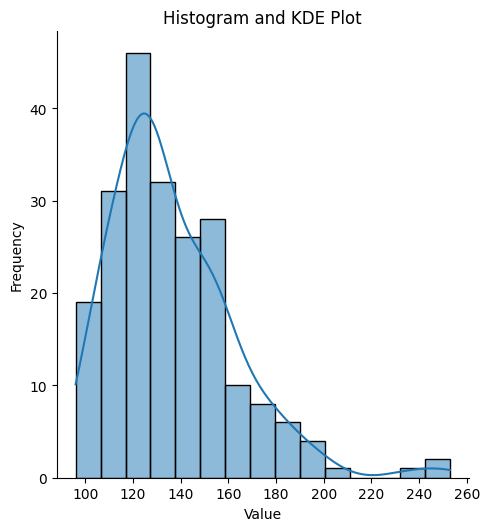

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot([x[0] for x in noise_degree_list], kde=True)  # kde=True 表示同时绘制核密度估计图
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram and KDE Plot')
plt.show()

In [16]:
# 确定异常的阈值
import numpy as np

mean = np.mean([x[0] for x in noise_degree_list]) # [score, page_id]
std = np.std([x[0] for x in noise_degree_list])

threshold = mean + 2 * std  # 假设以均值加上 2 个标准差为阈值

print("阈值为:", threshold)

阈值为: 188.63487736840406


In [17]:
# 拆分数据集
# 1. 先看超出阈值的有多少个
print([x for x in noise_degree_list if x[0] > 149])
print(len([x for x in noise_degree_list if x[0] > 188]))

[[170.15055724288914, 1227], [164.5222769245353, 1237], [156.1477615585785, 1248], [155.28040011461124, 1589], [167.16732255794625, 1795], [149.83345522878918, 1807], [180.44173409310898, 1808], [151.09658098075704, 1819], [172.2003736764471, 1823], [168.8547616232507, 1825], [160.9855271801569, 1929], [164.31583327801584, 1952], [152.85541745482175, 1959], [168.13046948775514, 1960], [156.3400417119515, 1981], [181.1601192693385, 1985], [164.40793430055476, 2053], [158.24161079753205, 2640], [150.2809436790253, 2645], [158.59871917495906, 2648], [171.0168588873617, 2659], [162.15008458969865, 2668], [151.6288481277399, 2670], [204.0976893677294, 2671], [154.82685056598433, 2673], [158.53200893223263, 2674], [158.1972586211703, 2676], [179.1962876112759, 2677], [149.48512556773133, 2682], [179.48253346623315, 2691], [157.4039444673781, 2693], [151.82749931341766, 2705], [159.47764467700762, 2713], [176.70376706519323, 2724], [155.5913562657863, 2725], [191.52924968421328, 2726], [151.3

In [18]:
# 想要全体的分数倒序，然后
noise_degree_list = [[int(x[0]), x[1]] for x in noise_degree_list]
noise_degree_list.sort(key=lambda x: x[0])
print(noise_degree_list)

[[95, 2661], [97, 1862], [98, 1860], [99, 2066], [101, 2664], [102, 1693], [102, 1702], [102, 1824], [102, 1863], [102, 1948], [103, 1692], [103, 2660], [103, 2662], [104, 1861], [104, 2665], [105, 1250], [105, 2766], [106, 1643], [106, 1831], [106, 2651], [106, 2687], [107, 2018], [107, 2639], [107, 2649], [108, 1699], [108, 2686], [108, 2688], [109, 1742], [110, 1249], [110, 2663], [110, 2706], [110, 2720], [111, 2715], [112, 1226], [112, 1247], [112, 1701], [113, 2656], [113, 2658], [114, 2046], [114, 2721], [115, 2689], [115, 2768], [115, 2770], [116, 1590], [116, 1700], [116, 1966], [116, 2013], [116, 2015], [116, 2644], [116, 2692], [117, 2729], [117, 2756], [118, 1949], [118, 2790], [119, 1686], [119, 1950], [120, 1642], [120, 1747], [120, 2035], [120, 2654], [120, 2723], [120, 2761], [121, 1953], [121, 2051], [121, 2646], [121, 2767], [122, 1299], [122, 1687], [122, 1927], [122, 2704], [123, 1298], [123, 1820], [123, 2045], [123, 2052], [123, 2675], [123, 2730], [123, 2778], [1

In [19]:
split_ratio = 0.3
skip_index = int(len(noise_degree_list)*(1-split_ratio))
score_skip_data_page = [x[1] for x in noise_degree_list][skip_index:]
len(score_skip_data_page)

65

In [20]:
# 拆分数据集
condition = eye_tracking_data['page_id'].isin(score_skip_data_page)
skip_data = eye_tracking_data[condition]
not_skip_data = eye_tracking_data[~condition]
print(len(skip_data))
print(len(not_skip_data))
skip_data.to_csv('data/final_data/skip_data.csv')
not_skip_data.to_csv('data/final_data/not_skip_data.csv')

65
149


# 生成单词level-fixation结合的数据集
* 主要是取交集

In [21]:
word_feature_with_correct = pd.read_csv('data/final_data/all-word-feature-20240723-103-with-correct.csv')
word_feature_without_correct = pd.read_csv('data/final_data/all-word-feature-20240723-103.csv')

In [22]:
word_feature_with_correct[word_feature_with_correct['page_id'].isin(score_skip_data_page)].to_csv('data/final_data/word-feature-with-correct-skip.csv')
word_feature_with_correct[~word_feature_with_correct['page_id'].isin(score_skip_data_page)].to_csv('data/final_data/word-feature-with-correct-not-skip.csv')
word_feature_without_correct[word_feature_without_correct['page_id'].isin(score_skip_data_page)].to_csv('data/final_data/word-feature-without-correct-skip.csv')
word_feature_without_correct[~word_feature_without_correct['page_id'].isin(score_skip_data_page)].to_csv('data/final_data/word-feature-without-correct-not-skip.csv')